In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
file_path = '/content/drive/MyDrive/ML/correos_limpios.csv'

In [64]:
#Inspeccionar primeras líneas para confirmar delimitador y formato
print("Primeras líneas del archivo:")
with open(file_path, 'r', encoding='utf-8') as f:
    for i in range(5):
        print(f.readline())

Primeras líneas del archivo:
from,to,cc,user,subject,body,clean_body,fecha,hora,weekday,horario,n_destinatarios

dhunter@smithandkempton.com,"['athomas@newenergy.com', 'alippin@mail.arco.com', 'cohnap@sce.com', '']",,dasovich-j,Newest draft of the letter,"Here is the latest draft. I think I got all the changes wanted by the Group.

If not, we can add them tomorrow.



Thanks,



In [65]:
# Cargar CSV con parámetros tolerantes
import pandas as pd
from ast import literal_eval

# Función segura para convertir strings de listas
def safe_eval_to_list(val):
    if pd.isnull(val):
        return []
    try:
        result = literal_eval(val)
        if isinstance(result, list):
            return result
        else:
            return []
    except (ValueError, SyntaxError):
        return []

# Cargar CSV tolerando errores de formato
df = pd.read_csv(
    file_path,
    sep=',',              # Confirmado por inspección visual
    quotechar='"',        # Maneja texto con comillas
    escapechar='\\',      # Por si hay comillas escapadas
    on_bad_lines='skip',  # Ignora líneas corruptas
    engine='python'       # Parser más tolerante
)

# Convertir columna 'to' a listas reales (si existe)
if 'to' in df.columns:
    df['to'] = df['to'].apply(safe_eval_to_list)

# Verificación
print("\nArchivo cargado correctamente")
print(df.info())
df.head()


Archivo cargado correctamente
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180012 entries, 0 to 180011
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   from             179885 non-null  object 
 1   to               180012 non-null  object 
 2   cc               10329 non-null   object 
 3   user             30978 non-null   object 
 4   subject          29655 non-null   object 
 5   body             30582 non-null   object 
 6   clean_body       30426 non-null   object 
 7   fecha            30531 non-null   object 
 8   hora             30528 non-null   object 
 9   weekday          30524 non-null   object 
 10  horario          30523 non-null   object 
 11  n_destinatarios  30523 non-null   float64
dtypes: float64(1), object(11)
memory usage: 16.5+ MB
None


,from,to,cc,user,subject,body,clean_body,fecha,hora,weekday,horario,n_destinatarios
0,dhunter@smithandkempton.com,"[athomas@newenergy.com, alippin@mail.arco.com,...",NaN,dasovich-j,Newest draft of the letter,Here is the latest draft. I think I got all th...,Here is the latest draft. I think I got all th...,2000-08-24,16.6,Thursday,laboral,4.0
1,dhunter@smithandkempton.com,"[athomas@newenergy.com, alippin@mail.arco.com,...",NaN,dasovich-j,Updated AB 1890 Retreat Agenda,Please see attached for the most up to date ve...,Please see attached for the most up to date ve...,2000-10-23,17.266666666666666,Monday,laboral,4.0
2,dhunter@smithandkempton.com,"[athomas@newenergy.com, alippin@mail.arco.com,...",NaN,dasovich-j,AB 1890 GROUP -- MEETING NOTICE -- NOTE TIME/L...,The next AB 1890 Implementation Group meeting ...,The next AB 1890 Implementation Group meeting ...,2000-08-15,16.633333333333333,Tuesday,laboral,4.0
3,dhunter@smithandkempton.com,"[alippin@mail.arco.com, cohnap@sce.com, anw@cp...",NaN,dasovich-j,2000 Annual Retreat,- Location memo.doc,Location memo.doc,2000-08-10,15.933333333333334,Thursday,laboral,4.0
4,dhunter@smithandkempton.com,"[athomas@newenergy.com, alippin@mail.arco.com,...",NaN,dasovich-j,FERC press release -- CA Action,http://www.ferc.fed.us/news1/pressreleases/cal...,Folks Above is the link to the FERC press rele...,2000-08-23,17.116666666666667,Wednesday,laboral,4.0


In [66]:
# Copia original por si queremos hacer análisis posterior o comparar
df_original = df.copy()

# Filtrar correos que tienen contenido real en 'clean_body'
df_filtrado = df[df['clean_body'].notnull() & (df['clean_body'].str.strip() != '')].copy()

# Mostrar cuántos se eliminan
num_descartados = len(df) - len(df_filtrado)
porcentaje = round(100 * num_descartados / len(df), 2)
print(f"Se han descartado {num_descartados} correos ({porcentaje}%) sin cuerpo limpio válido.")

Se han descartado 149586 correos (83.1%) sin cuerpo limpio válido.


# Temporalidad

In [67]:
# Asegurarnos de trabajar solo con correos válidos
df_temporal = df_filtrado.copy()

# 1. Asegurar que 'hora' sea numérica
df_temporal['hora'] = pd.to_numeric(df_temporal['hora'], errors='coerce')

# 2. Convertir a timedelta
df_temporal['hora_td'] = pd.to_timedelta(df_temporal['hora'], unit='h')

# 3. Crear columna tipo HH:MM
df_temporal['hora_hhmm'] = df_temporal['hora_td'].apply(
    lambda x: f"{int(x.total_seconds() // 3600):02d}:{int((x.total_seconds() % 3600) // 60):02d}" if pd.notnull(x) else None
)

# 4. Franja horaria manual
def clasificar_franja(hora_decimal):
    if pd.isnull(hora_decimal):
        return 'desconocido'
    if 6 <= hora_decimal < 12:
        return 'mañana'
    elif 12 <= hora_decimal < 18:
        return 'tarde'
    elif 18 <= hora_decimal < 24:
        return 'noche'
    else:
        return 'madrugada'

df_temporal['franja_horaria'] = df_temporal['hora'].apply(clasificar_franja)

# Convertir 'fecha' a datetime si aún no se ha hecho
df_temporal['fecha'] = pd.to_datetime(df_temporal['fecha'], errors='coerce')
print("Fechas no válidas:", df_temporal['fecha'].isnull().sum())

# 5. Día de la semana (por si 'weekday' original estaba mal)
df_temporal['dia_semana'] = df_temporal['fecha'].dt.day_name()

# 6. ¿Es fin de semana?
df_temporal['es_finde'] = df_temporal['fecha'].dt.weekday >= 5

# 7. ¿Es horario laboral? (lunes a viernes, 9 a 18)
df_temporal['es_laboral'] = (
    (df_temporal['es_finde'] == False) &
    (df_temporal['hora'] >= 9) & (df_temporal['hora'] <= 18)
)

# Verificamos resultados
df_temporal[['fecha', 'hora', 'hora_hhmm', 'franja_horaria', 'dia_semana', 'es_finde', 'es_laboral']].head(10)

Fechas no válidas: 44


,fecha,hora,hora_hhmm,franja_horaria,dia_semana,es_finde,es_laboral
0,2000-08-24,16.600000,16:36,tarde,Thursday,False,True
1,2000-10-23,17.266667,17:16,tarde,Monday,False,True
2,2000-08-15,16.633333,16:37,tarde,Tuesday,False,True
3,2000-08-10,15.933333,15:55,tarde,Thursday,False,True
4,2000-08-23,17.116667,17:07,tarde,Wednesday,False,True
5,2000-08-24,11.533333,11:31,mañana,Thursday,False,True
6,2000-08-24,16.566667,16:34,tarde,Thursday,False,True
7,2000-08-25,14.733333,14:43,tarde,Friday,False,True
8,2000-08-23,13.983333,13:58,tarde,Wednesday,False,True
9,2000-08-23,13.683333,13:40,tarde,Wednesday,False,True


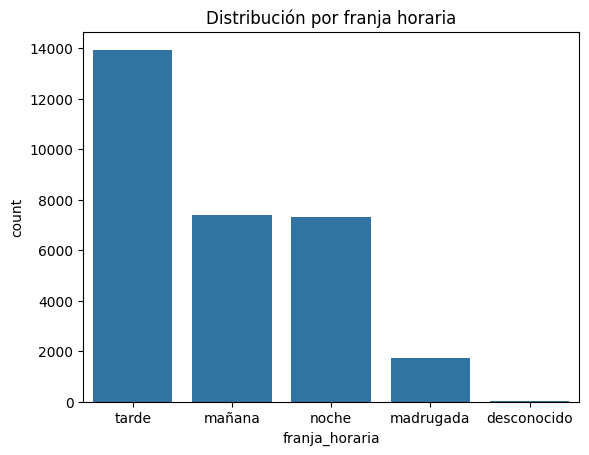

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_temporal, x='franja_horaria')
plt.title("Distribución por franja horaria")
plt.show()

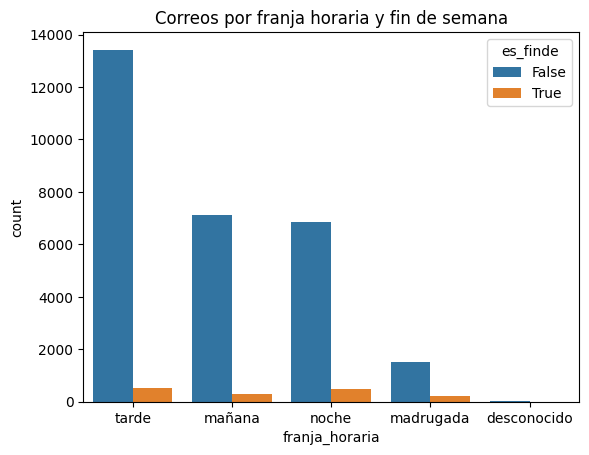

In [69]:
sns.countplot(data=df_temporal, x='franja_horaria', hue='es_finde')
plt.title("Correos por franja horaria y fin de semana")
plt.show()

In [70]:
import numpy as np

df_temporal['n_destinatarios'].describe(percentiles=[.25, .5, .75, .9, .95])

,n_destinatarios
count,30382.000000
mean,2.460536
std,11.351049
min,0.000000
25%,1.000000
50%,1.000000
75%,3.000000
90%,4.000000
95%,4.000000
max,223.000000


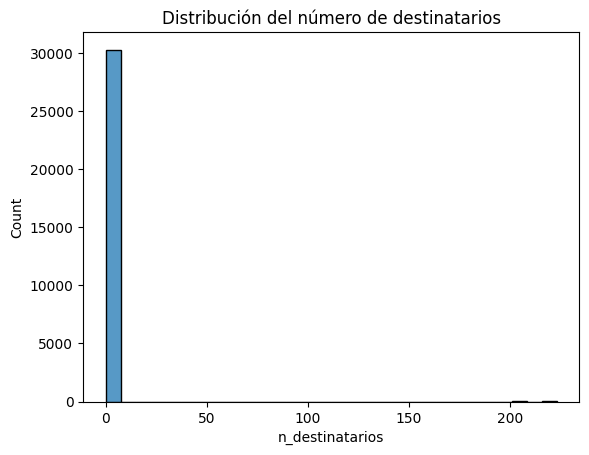

In [71]:
sns.histplot(df_temporal['n_destinatarios'], bins=30)
plt.title("Distribución del número de destinatarios")
plt.show()

# Heurística

In [72]:
urg_words = ['urgent', 'asap', 'immediately', 'please respond', 'need this today']
df_temporal['contains_urgent_word'] = df_temporal['clean_body'].str.lower().apply(
    lambda t: any(w in t for w in urg_words)
)

print("Correos con palabras de urgencia:", df_temporal['contains_urgent_word'].mean())

Correos con palabras de urgencia: 0.08029317031486229


In [73]:
def etiquetar_urgencia_refinada(row):
    text = str(row['clean_body']).lower()
    subject = str(row['subject']).lower() if pd.notnull(row['subject']) else ''

    contains_urgent = any(w in text for w in ['urgent', 'asap', 'immediately', 'please respond', 'need this today']) or \
                      any(w in subject for w in ['urgent', 'asap'])

    contains_important = any(w in text for w in ['review', 'important', 'follow up', 'please check']) or \
                         any(w in subject for w in ['action required', 'important'])

    is_routine = (row['n_destinatarios'] >= 3) and row['es_laboral'] and not contains_important and not contains_urgent

    off_hours = row['es_finde'] or not row['es_laboral']

    # Lógica basada en evidencia
    if contains_urgent:
        return 'urgente'
    if contains_important and off_hours:
        return 'urgente'
    if contains_important:
        return 'importante'
    if is_routine:
        return 'rutina'
    if off_hours:
        return 'importante'  # implicaría responsabilidad, pero no urgencia crítica
    return 'prescindible'

In [74]:
df_temporal['urgencia'] = df_temporal.apply(etiquetar_urgencia_refinada, axis=1)
distribucion = df_temporal['urgencia'].value_counts(normalize=True).sort_values(ascending=False) * 100

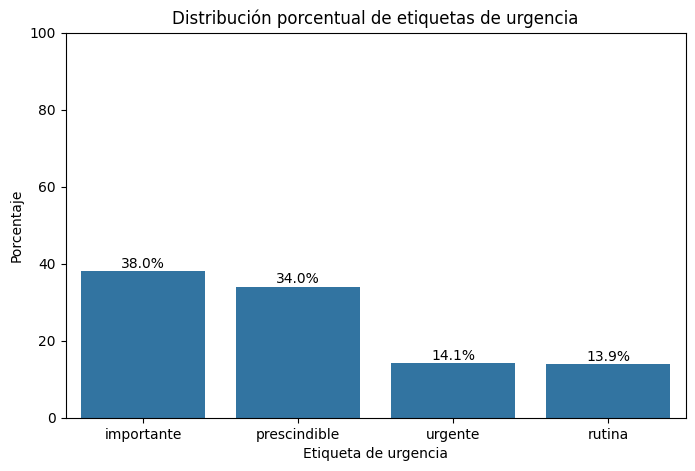

In [75]:
plt.figure(figsize=(8, 5))
sns.barplot(x=distribucion.index, y=distribucion.values)
plt.title("Distribución porcentual de etiquetas de urgencia")
plt.ylabel("Porcentaje")
plt.xlabel("Etiqueta de urgencia")
plt.ylim(0, 100)
for i, val in enumerate(distribucion.values):
    plt.text(i, val + 1, f"{val:.1f}%", ha='center')
plt.show()

In [76]:
for clase in df_temporal['urgencia'].unique():
    print(f"\n--- {clase.upper()} ---")
    muestras = df_temporal[df_temporal['urgencia'] == clase].sample(2, random_state=42)
    for _, row in muestras.iterrows():
        print("Subject:", row['subject'])
        print("Body:", row['clean_body'][:300], "...\n")


--- RUTINA ---
Subject: Re:RE: Re[2]: HD Case: Proposed Plan
Body: Jeff, just confirming that you will be initiating the call tonight?  Mark D. Guinney, CFA Consultant Watson Wyatt Investment Consulting 345 California Street, Ste. 1400 San Francisco, CA 94104 415 7334487 ph. 415 7334190 fax ...

Subject: NewsBeat:Daily News 11/08/2001
Body: NewsBeatDaily News 11082001 This email is a daily service of Forestweb  NewsBeat. All the stories from Thursday, Nov. 8, are available under Thursday's Headlines.  Newly posted on Forestweb CIBC World Markets. Canada  U.S. Lumber Dispute, Where Do We Go From Here? Click CIBC  download. If this NewsB ...


--- URGENTE ---
Subject: Special gift offer for Palm(tm) handheld owners
Body: At 129, it's a Gift!  Dear Jeffrey, Now, until October 1, 2001, when you buy the PalmTM m100 handheld for just 129 you'll receive three stylish faceplates for free! That's over 49 in savings. This special package makes a gift that anyone would love. Buy one for a friend

In [77]:
#!pip install transformers datasets scikit-learn --quiet

In [78]:
from transformers import AutoTokenizer, AutoModel
import torch

# Cargar modelo y tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()  # modo inferencia

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [79]:
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Usamos el embedding del token [CLS]
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

In [80]:
from sklearn.model_selection import train_test_split

sample_df = df_temporal.sample(2000, random_state=42).reset_index(drop=True)

# Separar un 10% para validación externa
df_model, df_holdout = train_test_split(sample_df, test_size=0.1, stratify=sample_df['urgencia'], random_state=42)

# Esto usaremos para entrenar como hasta ahora
df_model = df_model.reset_index(drop=True)
df_holdout = df_holdout.reset_index(drop=True)

# Extraer embeddings
X_embed = np.vstack(df_model['clean_body'].apply(get_cls_embedding))
y = df_model['urgencia']

In [81]:
from sklearn.preprocessing import StandardScaler

# Seleccionar columnas estructurales
cols_struct = ['hora', 'n_destinatarios', 'es_finde', 'es_laboral', 'contains_urgent_word']
X_struct = df_model[cols_struct].copy()

# Escalar numéricas
scaler = StandardScaler()
X_struct[['hora', 'n_destinatarios']] = scaler.fit_transform(X_struct[['hora', 'n_destinatarios']])

# Combinar embeddings con features estructurales
X_full = np.hstack([X_embed, X_struct.values])

# Random Forest Classifier


In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

# Split tradicional para evaluación posterior
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)

# 1. VALIDACIÓN CRUZADA
clf_cv = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(clf_cv, X_full, y, cv=5, scoring='f1_macro')
print(f"\n🔍 F1 macro promedio (validación cruzada 5-fold): {scores.mean():.4f}")
print(f"F1 macro por fold: {scores}")

# 2. ENTRENAMIENTO FINAL (con el split clásico)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluación clásica en test interno
y_pred = clf.predict(X_test)
print("\n📊 Evaluación en test (20% del total):")
print(classification_report(y_test, y_pred, digits=3))


🔍 F1 macro promedio (validación cruzada 5-fold): 0.6664
F1 macro por fold: [0.66665068 0.70566844 0.66745476 0.61424677 0.67811917]

📊 Evaluación en test (20% del total):
              precision    recall  f1-score   support

  importante      0.663     0.836     0.739       134
prescindible      0.758     0.897     0.822       126
      rutina      0.652     0.300     0.411        50
     urgente      0.947     0.360     0.522        50

    accuracy                          0.717       360
   macro avg      0.755     0.598     0.623       360
weighted avg      0.734     0.717     0.692       360



In [83]:
# Creamos índices antes del split
indices = df_model.index
idx_train, idx_test = train_test_split(indices, test_size=0.2, stratify=df_model['urgencia'], random_state=42)

# Crear DataFrame de test
df_test = df_model.loc[idx_test].copy()
df_test['true'] = df_model.loc[idx_test]['urgencia']
df_test['pred'] = y_pred

# Filtrar errores
errores = df_test[df_test['true'] != df_test['pred']]
print(f"Número de errores: {len(errores)}")

Número de errores: 102


In [84]:
def mostrar_errores(clase_real, clase_predicha, n=3):
    subset = errores[(errores['true'] == clase_real) & (errores['pred'] == clase_predicha)]
    muestras = subset.sample(min(n, len(subset)), random_state=1)

    for i, (_, row) in enumerate(muestras.iterrows(), 1):
        print(f"\n🔹 Ejemplo {i}")
        print(f"❌ Real: {row['true']} | 🔮 Predicho: {row['pred']}")
        print(f"Asunto: {row['subject']}")
        print(f"Cuerpo: {row['clean_body'][:400]}...")

In [85]:
mostrar_errores('urgente', 'importante')
mostrar_errores('urgente', 'prescindible')
mostrar_errores('rutina', 'importante')
mostrar_errores('importante', 'prescindible')


🔹 Ejemplo 1
❌ Real: urgente | 🔮 Predicho: importante
Asunto: Thank you for your Contribution!  Together we CAN change lives!
Cuerpo: Thank you for changing lives. Employee ID 90009718 Name MICHELLE H CASH Payment Amount 650.00 Payment Method Deduct a portion from each paycheck Leadership Giving Roster Listed at the President Make a Difference Club Not Applicable Mailing Address 4531 BEECH ST BELLAIRE , TX 77401 US Your donation is designated for SEARCH Written Acknowledgement of Contribution NO "You will find, as you look back ...

🔹 Ejemplo 2
❌ Real: urgente | 🔮 Predicho: importante
Asunto: RTO West RRG Days Feb. 11 & 12 - Agenda
Cuerpo: Hello, Everyone  RTO West will hold two days of meetings Monday, February 11, and Tuesday, February 12, 2002 to review, discuss and seek consensus on the draft filing that RTO West is preparing to submit to FERC. The meetings will give Regional Representatives an opportunity to prioritize and explain their key issues to the RTO West principals before

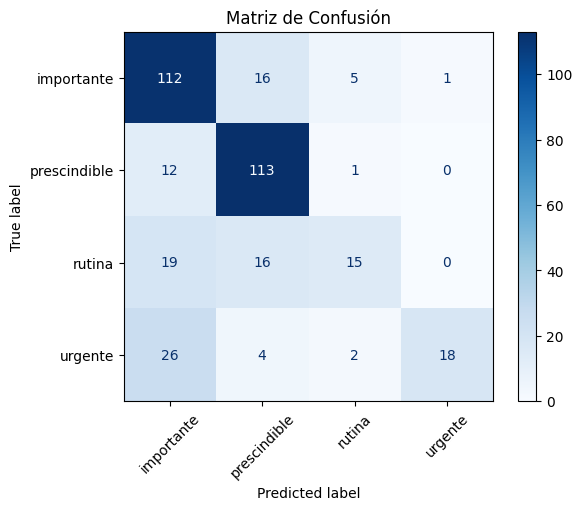

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=clf.classes_, xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

  importante      0.663     0.836     0.739       134
prescindible      0.758     0.897     0.822       126
      rutina      0.652     0.300     0.411        50
     urgente      0.947     0.360     0.522        50

    accuracy                          0.717       360
   macro avg      0.755     0.598     0.623       360
weighted avg      0.734     0.717     0.692       360



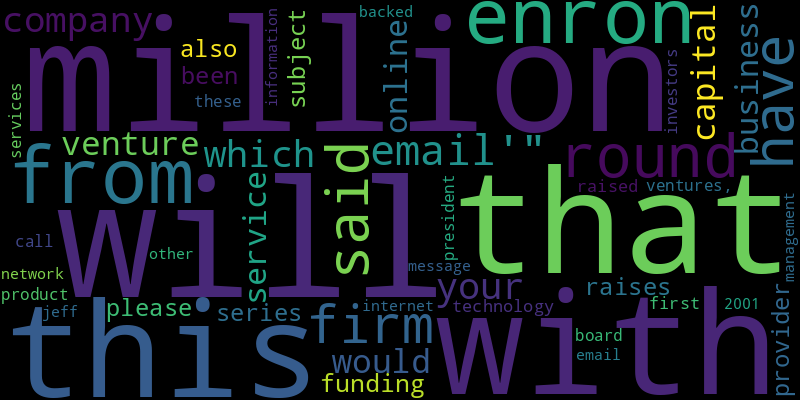

In [88]:
from collections import Counter
from wordcloud import WordCloud

# Palabras frecuentes en errores de urgente mal clasificados
textos_error = errores[errores['true'] == 'urgente']['clean_body'].str.lower().str.cat(sep=' ')
palabras = [w for w in textos_error.split() if len(w) > 3]
frecuentes = Counter(palabras).most_common(50)
WordCloud(width=800, height=400).generate_from_frequencies(dict(frecuentes)).to_image()

Palabras frecuentes: *please, will, message, contact, meeting, sent, attached, email, subject*

Ninguna palabra especialmente crítica como asap, urgent, immediately, etc.

Esto indica que el modelo no ha aprendido señales de urgencia fuertes en estos casos. Podría deberse a:

  - El texto de entrenamiento no contiene urgencia explícita.

  - Las etiquetas heurísticas están en conflicto con el contenido real.

  - O bien: los embeddings de DistilBERT no están diferenciando bien las clases.

# XGBoost

In [92]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import numpy as np

# Codificar etiquetas (necesario para XGBoost)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Modelo XGBoost
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Validación cruzada
cv_scores = cross_val_score(xgb, X_full, y_enc, cv=5, scoring='f1_weighted')
print(f"F1 ponderado medio (5-fold CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:05:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:05:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:06:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:06:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:06:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

F1 ponderado medio (5-fold CV): 0.8603 ± 0.0102


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:10:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Reporte de clasificación (XGBoost sobre test set holdout):
              precision    recall  f1-score   support

  importante      0.803     0.791     0.797       134
prescindible      0.884     0.968     0.924       126
      rutina      0.842     0.960     0.897        50
     urgente      0.879     0.580     0.699        50

    accuracy                          0.847       360
   macro avg      0.852     0.825     0.829       360
weighted avg      0.847     0.847     0.842       360



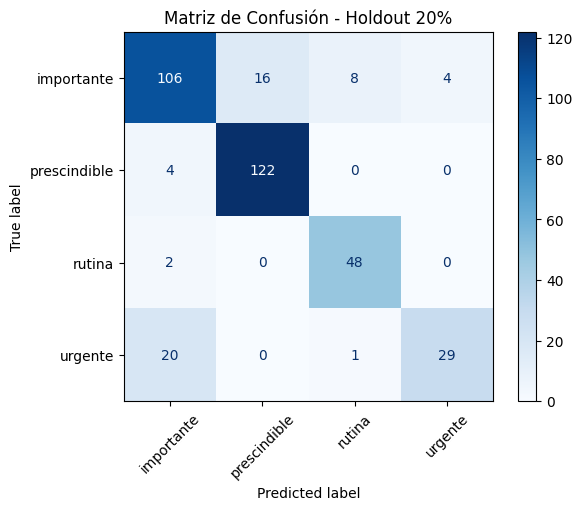

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Dividir manualmente para análisis visual
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, stratify=y, random_state=42)

# Codificar
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

# Entrenar sobre train
xgb.fit(X_train, y_train_enc)

# Predecir sobre test
y_pred_enc = xgb.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_enc)

# Evaluación
print("Reporte de clasificación (XGBoost sobre test set holdout):")
print(classification_report(y_test, y_pred_xgb, digits=3))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, labels=le.classes_, xticks_rotation=45, cmap='Blues')
plt.title("Matriz de Confusión - Holdout 20%")
plt.show()

# Errores graves por categoría

In [94]:
# Crear DataFrame de resultados con variables originales
df_resultado = df_filtrado.iloc[y_test.index].copy()
df_resultado['real'] = y_test
df_resultado['pred'] = y_pred  # o y_pred_xgb si estás usando XGBoost

In [95]:
# Suponiendo que tienes y_test y y_pred con las etiquetas REALES y PREDICHAS
errores_urgentes = df_resultado[
    (df_resultado['real'] == 'urgente') &
    (df_resultado['pred'] != 'urgente')
]

errores_graves = df_resultado[
    (df_resultado['real'] == 'urgente') &
    (df_resultado['pred'].isin(['prescindible', 'rutina']))
]

errores_inversos = df_resultado[
    (df_resultado['real'] == 'prescindible') &
    (df_resultado['pred'] == 'urgente')
]

# Mostrar ejemplos
print("Errores graves (urgente mal clasificado):")
display(errores_graves[['subject', 'clean_body', 'real', 'pred']].head(5))

print("Urgente → rutina/prescindible: ", len(errores_graves))
print("Prescindible → urgente: ", len(errores_inversos))

Errores graves (urgente mal clasificado):


,subject,clean_body,real,pred
1363,Enron Global Government Affairs Promotions,I am pleased to announce that effective July 1...,urgente,rutina


Urgente → rutina/prescindible:  1
Prescindible → urgente:  2




---


Patrones de palabras en los errores graves para futuras mejoras

---



In [96]:
from collections import Counter
palabras_graves = ' '.join(errores_graves['clean_body'].dropna()).lower().split()
Counter([w for w in palabras_graves if len(w) > 4]).most_common(20)

[('enron', 6),
 ('retail', 4),
 ('wholesale', 4),
 ('electricity', 4),
 ('issues', 3),
 ('england', 3),
 ('services', 3),
 ('value', 3),
 ('individuals', 2),
 ('years', 2),
 ('during', 2),
 ('course', 2),
 ('ensuring', 2),
 ('energy', 2),
 ('participation', 2),
 ('played', 2),
 ('critical', 2),
 ("rob's", 2),
 ('canada', 2),
 ('year.', 2)]

# Validación frente a Holdout Set

🔒 Evaluación final sobre el set de validación externa (holdout 10%):
              precision    recall  f1-score   support

  importante      0.864     0.770     0.814        74
prescindible      0.863     0.986     0.920        70
      rutina      0.818     0.964     0.885        28
     urgente      1.000     0.750     0.857        28

    accuracy                          0.870       200
   macro avg      0.886     0.868     0.869       200
weighted avg      0.876     0.870     0.867       200



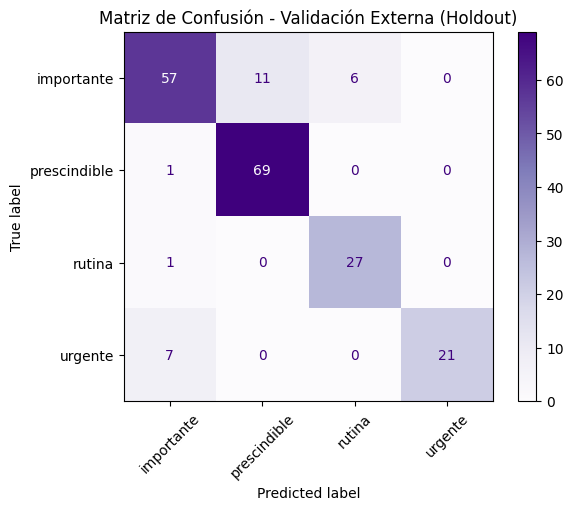

In [97]:
# 1. Embeddings para holdout
X_holdout_embed = np.vstack(df_holdout['clean_body'].apply(get_cls_embedding))

# 2. Features estructurales
X_holdout_struct = df_holdout[cols_struct].copy()
X_holdout_struct[['hora', 'n_destinatarios']] = scaler.transform(X_holdout_struct[['hora', 'n_destinatarios']])

# 3. Combinar todo
X_holdout_full = np.hstack([X_holdout_embed, X_holdout_struct.values])
y_holdout = df_holdout['urgencia']
y_holdout_enc = le.transform(y_holdout)

# 4. Predecir con el mejor modelo (XGBoost entrenado previamente)
y_holdout_pred_enc = xgb.predict(X_holdout_full)
y_holdout_pred = le.inverse_transform(y_holdout_pred_enc)

# 5. Evaluación final
print("🔒 Evaluación final sobre el set de validación externa (holdout 10%):")
print(classification_report(y_holdout, y_holdout_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(y_holdout, y_holdout_pred, labels=le.classes_, xticks_rotation=45, cmap='Purples')
plt.title("Matriz de Confusión - Validación Externa (Holdout)")
plt.show()